# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

# Import Library

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [4]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [7]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [8]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [9]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [14]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [12]:
df.booking_complete.value_counts(normalize=True)

0    0.85044
1    0.14956
Name: booking_complete, dtype: float64

#### target kita imbalance, kita coba predict tanpa resample dan pakai resample

In [23]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [43]:
df.shape

(50000, 14)

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

# EDA (Exploratory Data Analysis)

### Sales Channel

In [25]:
df.sales_channel.value_counts()

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64

In [26]:
sales_internet = df.sales_channel.value_counts().values[0]  / df.sales_channel.count() *100
sales_mobile = df.sales_channel.value_counts().values[1]  / df.sales_channel.count() *100

print("Internet sales: {:.2f}%".format(sales_internet))
print("Mobile sales: {:.2f}%".format(sales_mobile))

Internet sales: 88.76%
Mobile sales: 11.24%


<AxesSubplot: xlabel='sales_channel', ylabel='count'>

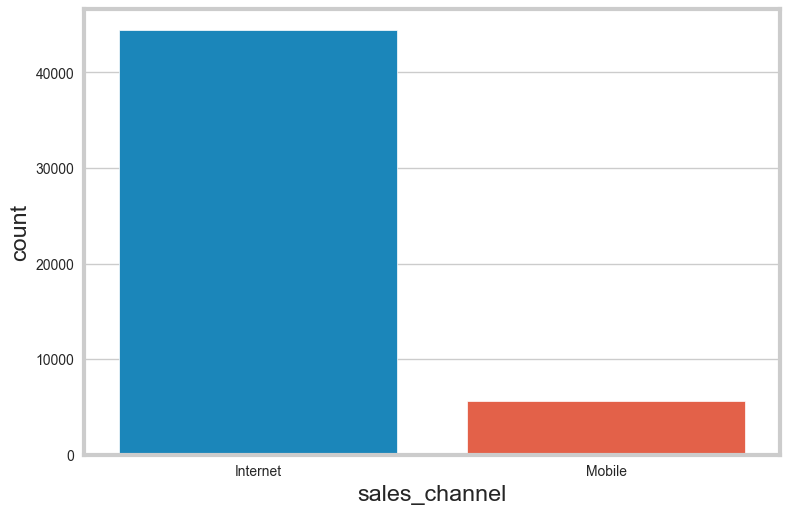

In [34]:
sns.countplot(x="sales_channel", data=df)

### Trip Type

In [28]:
df.trip_type.value_counts()

RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64

In [29]:
trip_round = df.trip_type.value_counts().values[0]  / df.trip_type.count() *100
trip_oneway = df.trip_type.value_counts().values[1]  / df.trip_type.count() *100
trip_circle = df.trip_type.value_counts().values[2]  / df.trip_type.count() *100

print("Round trip: {:.2f}%".format(trip_round))
print("Oneway trip: {:.2f}%".format(trip_oneway))
print("Circle trip: {:.2f}%".format(trip_circle))

Round trip: 98.99%
Oneway trip: 0.77%
Circle trip: 0.23%


<AxesSubplot: xlabel='trip_type', ylabel='count'>

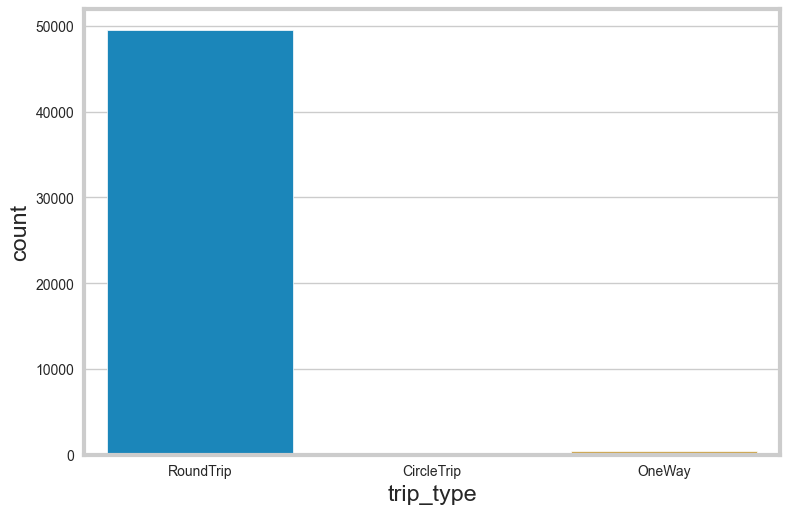

In [33]:
sns.countplot(x="trip_type", data=df)

### Puchase Lead

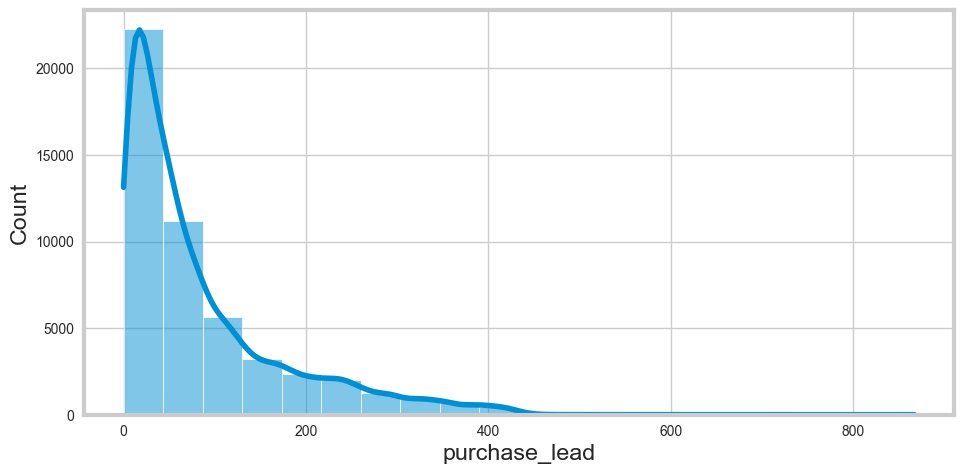

In [37]:
# distribution data puchase_lead
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="purchase_lead", kde=True, bins=20)
plt.show()

#### ada pemesanan yang dilakukan lebih dari 2 tahun sebelum tanggal perjalanan dan tampak nya sangat tidak mungkin. kita anggap saja outlier

In [46]:
(df.purchase_lead > 600).value_counts()

False    49992
True         8
Name: purchase_lead, dtype: int64

In [47]:
df[df.purchase_lead > 600]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
835,3,Internet,RoundTrip,641,46,6,7,AKLKUL,Malaysia,1,0,1,8.83,1
6148,1,Internet,RoundTrip,614,19,11,3,COKMEL,Australia,0,0,0,8.83,0
24119,1,Internet,RoundTrip,704,23,8,2,PNHSYD,Australia,0,0,0,8.58,0
38356,2,Internet,RoundTrip,633,5,10,6,HKTOOL,Australia,0,0,1,8.83,0
39417,1,Mobile,RoundTrip,625,5,15,5,ICNRGN,Myanmar (Burma),0,0,0,6.62,0
42916,1,Mobile,RoundTrip,605,6,18,4,BLRMEL,India,0,0,0,8.83,0
46716,2,Internet,RoundTrip,606,6,6,5,HKTTPE,United States,0,0,1,4.67,0
48259,3,Internet,RoundTrip,867,6,7,1,KIXMLE,Japan,0,0,1,7.00,1


#### jika kita asumsikan tidak ada pelanggan yang memesan lebih awal dari 1 setengah tahun, maka kita akan hapus data yang lebih dari 600 hari

In [49]:
df = df[df.purchase_lead < 600]
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [56]:
df.shape

(49992, 14)

###  Length of Stay

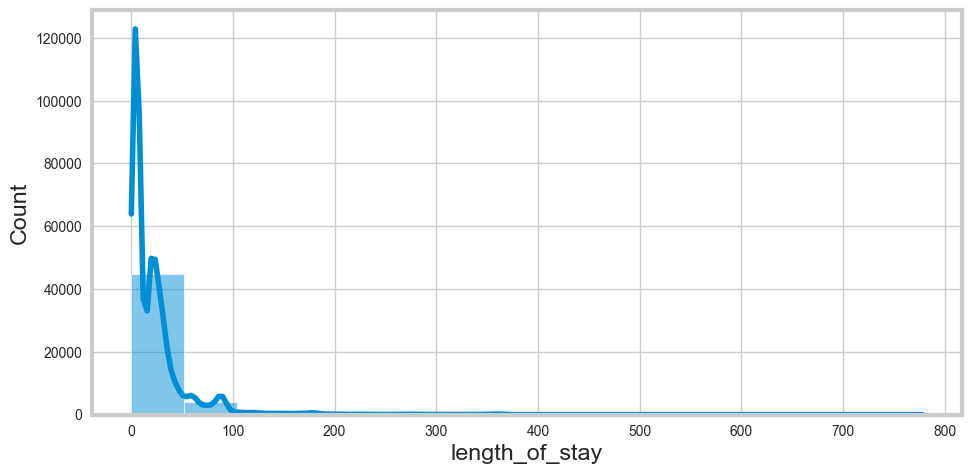

In [51]:
# distribution data length_of_stay
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="length_of_stay", kde=True, bins=15)
plt.show()

#### maari kita cek berapa banyak data yang melebihi lama tinggal lebih 200 hari

In [53]:
(df.length_of_stay > 200).value_counts()

False    49713
True       279
Name: length_of_stay, dtype: int64

In [55]:
df[df.length_of_stay > 500].booking_complete.value_counts()

0    9
1    1
Name: booking_complete, dtype: int64

#### Kita perlu memiliki lebih banyak pengetahuan bisnis untuk memutuskan apakah akan menghapus entri ini dengan masa inap lebih dari 600 hari. Mungkin ada banyak alasan untuk pemesanan tersebut. Namun untuk saat ini, kami hanya ingin fokus pada pemesanan yang dilakukan untuk lama tinggal kurang dari 500 hari.

In [57]:
df = df[df.length_of_stay < 500]
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [58]:
df.shape

(49982, 14)

### Booking Origin

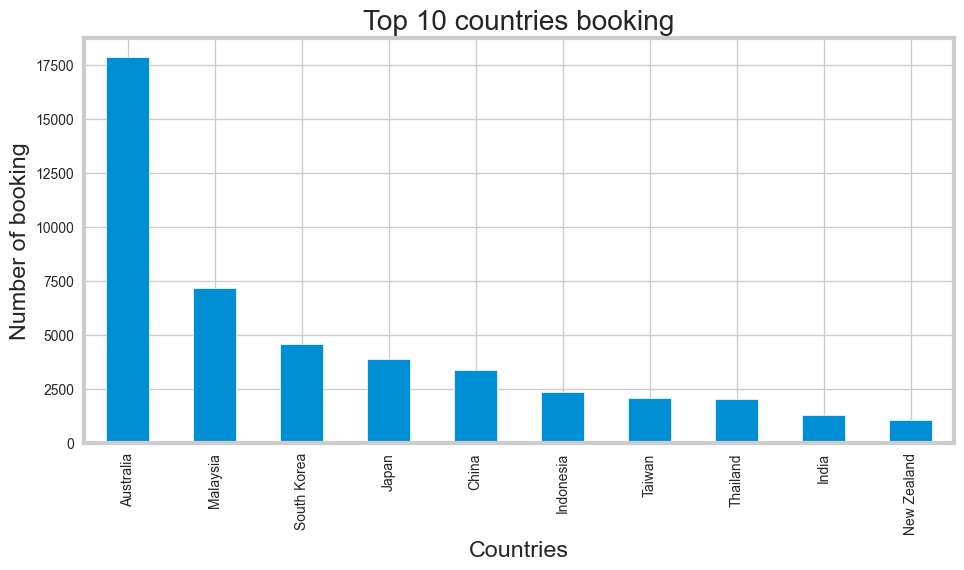

In [60]:
plt.figure(figsize=(10, 5))
ax = df.booking_origin.value_counts()[:10].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of booking")
ax.set_title("Top 10 countries booking")
plt.show()

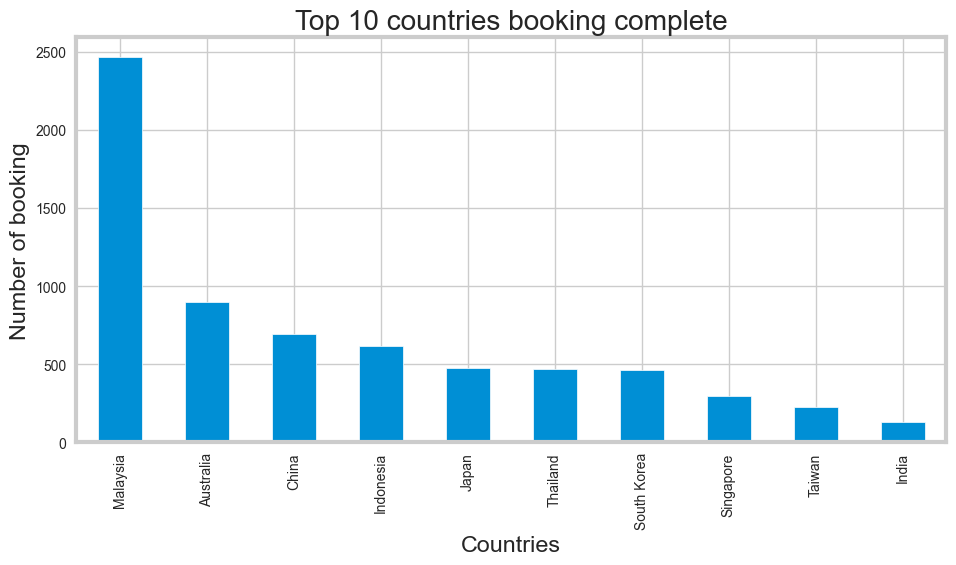

In [61]:
plt.figure(figsize=(10, 5))
ax = df[df.booking_complete == 1].booking_origin.value_counts()[:10].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of booking")
ax.set_title("Top 10 countries booking complete")
plt.show()

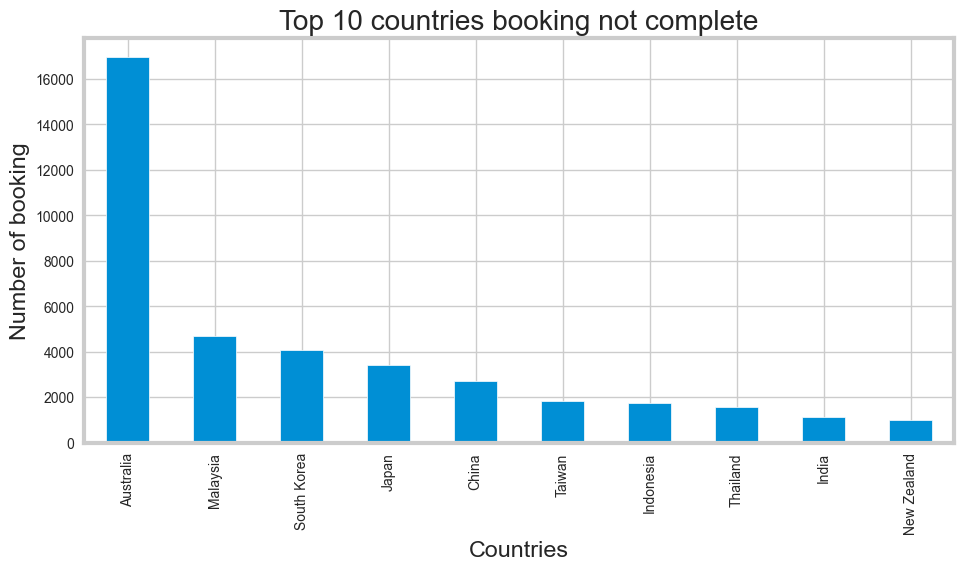

In [62]:
plt.figure(figsize=(10, 5))
ax = df[df.booking_complete == 0].booking_origin.value_counts()[:10].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of booking")
ax.set_title("Top 10 countries booking not complete")
plt.show()

In [65]:
print('percentage booking success: {:.2f}%'.format((df.booking_complete == 1).sum() / df.booking_complete.count() * 100))
print('percentage booking failure: {:.2f}%'.format((df.booking_complete == 0).sum() / df.booking_complete.count() * 100))

percentage booking success: 14.96%
percentage booking failure: 85.04%


### Correlation

C:\Users\Silent Monster\AppData\Local\Temp\ipykernel_3984\2768620844.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


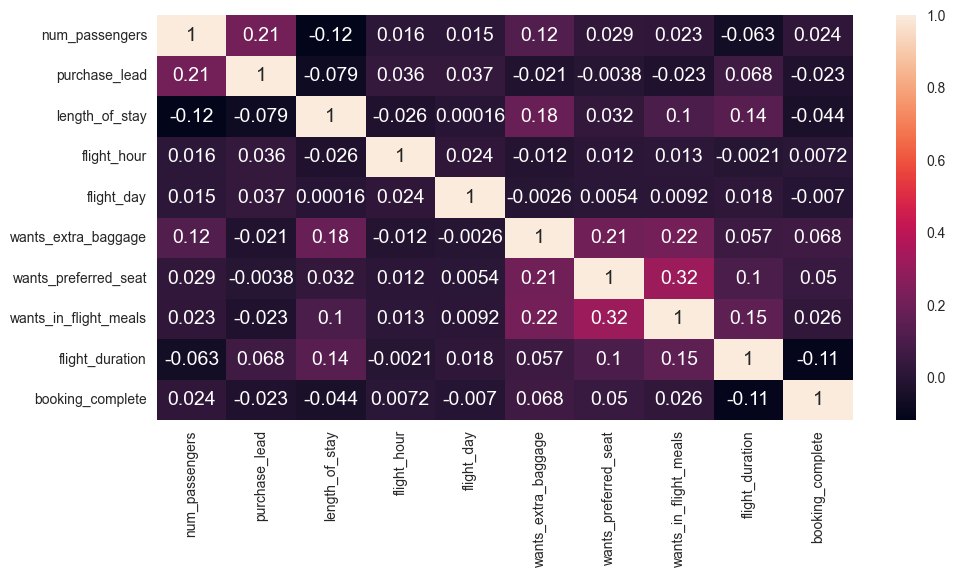

In [71]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [76]:
# Drop column yang tidak penting
df.drop(['route'], axis=1, inplace=True)

C:\Users\Silent Monster\AppData\Local\Temp\ipykernel_3984\3838949417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['route'], axis=1, inplace=True)


# Dataset Spliting

In [79]:
X = df.drop(columns="booking_complete")
y = df.booking_complete

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39985, 12), (9997, 12), (39985,), (9997,))

# Training

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [81]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [82]:
X_train.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
44319,2,Mobile,RoundTrip,53,6,9,6,India,1,0,0,5.52
27152,1,Internet,RoundTrip,44,3,11,3,United Kingdom,0,0,0,7.00
3327,1,Internet,RoundTrip,32,24,12,7,Australia,1,1,1,8.83
7011,4,Internet,RoundTrip,34,24,11,6,Australia,1,1,1,8.58
36548,2,Internet,RoundTrip,31,5,14,4,India,1,0,0,5.52


In [86]:
df.wants_in_flight_meals.value_counts()

0    28636
1    21346
Name: wants_in_flight_meals, dtype: int64

In [83]:
X_train.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'booking_origin',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration'],
      dtype='object')

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["num_passengers", "purchase_lead", "length_of_stay", "flight_hour", "flight_day", "flight_duration"]),
    ('categoric', cat_pipe(encoder='onehot'), ["sales_channel", "trip_type", "booking_origin", 'wants_extra_baggage', 
                                               'wants_preferred_seat', 'wants_in_flight_meals']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])


model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
